# Day 7: Interview Review & Multi-Asset Neural Predictor Project

## Week 13 - Neural Networks in Quantitative Finance

---

## Overview

This notebook consolidates Week 13's neural network learning with:

1. **10 Neural Network Interview Questions** - With detailed answers
2. **Common Pitfalls** - What to avoid when applying NNs to finance
3. **When NOT to Use Neural Networks** - Know the limitations
4. **Mini-Project** - Build a multi-asset neural predictor
5. **Linear Baseline Comparison** - Always compare to simple models
6. **Week Summary** - Key takeaways

### European Market Considerations 🇪🇺

- MiFID II model governance requirements
- Cross-border trading considerations
- European market hours and calendar
- Multi-currency handling

---

## Part 1: Neural Network Interview Questions

### Interview Preparation Guide

These questions cover the most common topics asked in quant/ML interviews at trading firms, hedge funds, and investment banks.

---

### Question 1: Vanishing/Exploding Gradients

**Q: Explain the vanishing and exploding gradient problems. How do they specifically affect trading models, and what solutions would you implement?**

#### Answer:

**Vanishing Gradients:**
- Gradients become exponentially small as they propagate backward through layers
- Caused by activation functions like sigmoid/tanh that squash values to small ranges
- Early layers stop learning as gradient approaches zero

**Exploding Gradients:**
- Gradients become exponentially large during backpropagation
- Causes numerical overflow and unstable training
- Weights oscillate wildly or become NaN

**Impact on Trading Models:**
- Financial signals are often subtle; vanishing gradients prevent learning weak patterns
- Market regime changes can cause sudden gradient explosions
- Both issues lead to unreliable predictions

**Solutions:**
1. **ReLU/GELU activations** - Don't saturate for positive values
2. **Batch Normalization** - Normalizes layer inputs, stabilizes gradients
3. **Residual Connections** - Provide gradient highway to early layers
4. **Gradient Clipping** - Cap gradient magnitude (e.g., max_norm=1.0)
5. **Proper Initialization** - Xavier/He initialization
6. **LSTM/GRU gates** - For sequential models, gates control gradient flow

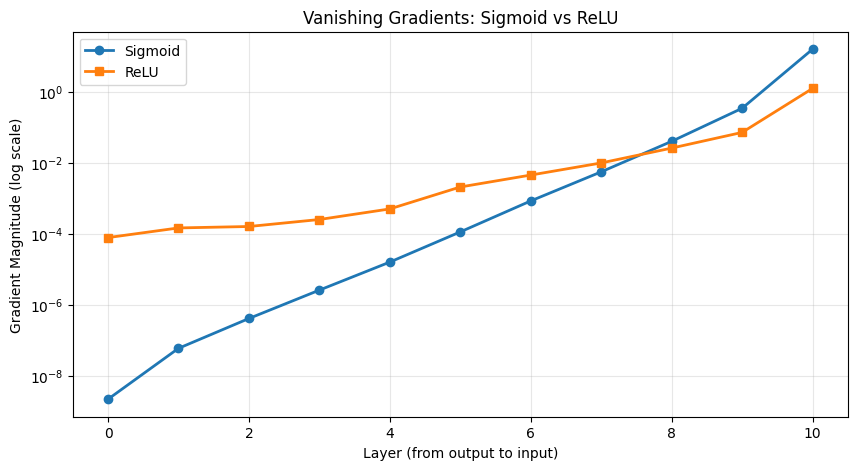

Sigmoid gradient at first layer: 1.55e+01
ReLU gradient at first layer: 1.22e+00


In [1]:
# Demonstration: Vanishing gradients with sigmoid vs ReLU
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def demonstrate_gradient_flow(activation='sigmoid', n_layers=10):
    """
    Demonstrate gradient magnitude at each layer.
    Shows how gradients vanish with sigmoid but not ReLU.
    """
    # Build deep network
    layers = []
    for i in range(n_layers):
        layers.append(nn.Linear(32, 32))
        if activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        else:
            layers.append(nn.ReLU())
    
    model = nn.Sequential(*layers, nn.Linear(32, 1))
    
    # Forward pass
    x = torch.randn(32, 32, requires_grad=True)
    output = model(x)
    loss = output.sum()
    
    # Backward pass
    loss.backward()
    
    # Collect gradient magnitudes
    grad_magnitudes = []
    for i, layer in enumerate(model):
        if isinstance(layer, nn.Linear):
            grad_mag = layer.weight.grad.abs().mean().item()
            grad_magnitudes.append(grad_mag)
    
    return grad_magnitudes

# Compare
sigmoid_grads = demonstrate_gradient_flow('sigmoid')
relu_grads = demonstrate_gradient_flow('relu')

# Plot
plt.figure(figsize=(10, 5))
plt.semilogy(sigmoid_grads, 'o-', label='Sigmoid', linewidth=2)
plt.semilogy(relu_grads, 's-', label='ReLU', linewidth=2)
plt.xlabel('Layer (from output to input)')
plt.ylabel('Gradient Magnitude (log scale)')
plt.title('Vanishing Gradients: Sigmoid vs ReLU')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Sigmoid gradient at first layer: {sigmoid_grads[-1]:.2e}")
print(f"ReLU gradient at first layer: {relu_grads[-1]:.2e}")

---

### Question 2: Overfitting in Financial ML

**Q: How do you detect and prevent overfitting in financial machine learning? Why is overfitting particularly dangerous in trading?**

#### Answer:

**Why Overfitting is Dangerous in Trading:**
- Financial data has low signal-to-noise ratio
- Past patterns may not repeat (non-stationarity)
- Overfit models give false confidence → trading losses
- Survivorship bias amplifies overfitting risk

**Detection Methods:**
1. **Train/Validation Gap** - Large gap indicates overfitting
2. **Walk-Forward Testing** - Performance degrades in later periods
3. **Multiple Seeds** - Inconsistent results across seeds
4. **Feature Importance** - Model relies on noise features

**Prevention Techniques:**
1. **Regularization** - L1/L2 (weight decay), dropout
2. **Early Stopping** - Stop when validation loss increases
3. **Data Augmentation** - Bootstrap, noise injection
4. **Ensemble Methods** - Combine multiple models
5. **Simpler Models** - Start simple, add complexity only if needed
6. **Cross-Validation** - Walk-forward or purged k-fold

---

### Question 3: Batch Normalization

**Q: Explain batch normalization. What are the challenges of using it in financial time series prediction?**

#### Answer:

**What Batch Normalization Does:**
- Normalizes layer inputs: $\hat{x} = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$
- Learnable parameters $\gamma$ (scale) and $\beta$ (shift)
- Reduces internal covariate shift
- Enables higher learning rates

**Challenges in Financial Time Series:**

1. **Non-Stationarity**: Financial data statistics change over time; batch stats may not generalize

2. **Small Batch Sizes**: Financial datasets are often small; batch statistics are noisy

3. **Train/Inference Mismatch**: Running statistics computed during training may not match deployment conditions

4. **Sequential Data**: In time series, batch norm can leak information across samples

**Alternatives:**
- **Layer Normalization** - Normalizes across features, not batch
- **Instance Normalization** - Per-sample normalization
- **Group Normalization** - Groups of channels

---

### Question 4: Loss Functions for Trading

**Q: What loss functions would you use for different trading problems? Discuss classification vs regression in trading context.**

#### Answer:

**Classification (Signal Prediction):**
- **Binary Cross-Entropy**: Standard for up/down prediction
- **Focal Loss**: When signals are rare (imbalanced classes)
- **Weighted BCE**: When false positives/negatives have different costs

**Regression (Return Prediction):**
- **MSE**: Standard, sensitive to outliers
- **MAE (L1)**: Robust to outliers
- **Huber Loss**: Combines MSE (small errors) and MAE (large errors)
- **Quantile Loss**: For predicting specific quantiles (VaR)

**Trading-Specific Losses:**
- **Sharpe Ratio Loss**: Directly optimize risk-adjusted returns
- **Maximum Drawdown Loss**: Penalize large drawdowns
- **Profit/Loss Loss**: Actual P&L as loss function

**Key Insight:**
Classification is often preferred because:
- Easier to achieve edge in direction than magnitude
- More robust to outliers
- Natural for trading decisions (buy/sell/hold)

---

### Question 5: Feature Engineering for Neural Networks

**Q: Do neural networks need feature engineering? What features work well for financial prediction?**

#### Answer:

**Do NNs Need Feature Engineering?**
- Theoretical: NNs can learn any function → features not needed
- Practical: Feature engineering significantly improves performance
- Financial data has structure that features can exploit

**Effective Financial Features:**

1. **Returns & Momentum**:
   - Multi-horizon returns (1d, 5d, 20d, 60d)
   - Momentum indicators

2. **Volatility**:
   - Rolling standard deviation
   - GARCH features
   - ATR (Average True Range)

3. **Mean Reversion**:
   - Price relative to moving average
   - RSI, Bollinger Band position

4. **Volume**:
   - Volume relative to average
   - On-balance volume
   - Volume-price correlation

5. **Cross-Asset**:
   - Sector returns
   - Index correlation
   - Currency exposure

6. **Calendar Effects**:
   - Day of week
   - Month, quarter
   - Days to expiry (for derivatives)

---

### Question 6: Architecture Selection

**Q: How do you choose between MLP, CNN, and RNN for financial time series? What about Transformers?**

#### Answer:

| Architecture | Best For | Financial Use Case |
|-------------|----------|--------------------|
| **MLP** | Tabular features | Factor models, cross-sectional prediction |
| **CNN** | Local patterns | Chart pattern recognition, multi-scale features |
| **RNN/LSTM** | Sequential dependencies | Time series forecasting, regime detection |
| **Transformer** | Long-range dependencies | Multi-asset, attention-based allocation |

**Selection Criteria:**

1. **Data Structure**:
   - Tabular (features per time point) → MLP
   - Raw sequence → LSTM or Transformer
   - Image-like (price charts) → CNN

2. **Sequence Length**:
   - Short sequences (<100) → LSTM
   - Long sequences (>100) → Transformer

3. **Interpretability**:
   - Attention mechanisms provide interpretability
   - Important for regulatory compliance

4. **Data Size**:
   - Small data → MLP (fewer parameters)
   - Large data → Can use more complex architectures

**Practical Advice:**
- Start with MLP on engineered features
- Add complexity only if justified by validation performance

---

### Question 7: Backpropagation Through Time

**Q: Explain backpropagation through time (BPTT) and its limitations. How does truncated BPTT help?**

#### Answer:

**BPTT Concept:**
- Unrolls RNN across time steps
- Computes gradients by backpropagating through all time steps
- Each time step contributes to the gradient

**Limitations:**
1. **Memory**: Must store activations for all time steps
2. **Computation**: Gradient computation scales with sequence length
3. **Vanishing Gradients**: Gradients diminish for long sequences

**Truncated BPTT:**
- Only backpropagate through last k time steps
- Reduces memory and computation
- Trade-off: Cannot learn very long-term dependencies

**Financial Implications:**
- Market regimes can persist for months → need long sequences
- Truncation may miss regime changes
- Alternative: Use Transformers for long-range dependencies

---

### Question 8: Regularization Techniques

**Q: Compare L1, L2 regularization, and dropout. When would you use each in a trading model?**

#### Answer:

| Technique | Effect | When to Use |
|-----------|--------|-------------|
| **L1 (Lasso)** | Sparsity, feature selection | Many features, want interpretability |
| **L2 (Ridge)** | Small weights, no sparsity | Standard choice, prevent large weights |
| **Dropout** | Ensemble effect | Deep networks, overfitting prone |
| **Elastic Net** | L1 + L2 combination | Best of both worlds |

**Trading-Specific Guidance:**

1. **Factor Models** → L1 for feature selection (identify important factors)

2. **Deep Networks** → Dropout (0.2-0.5) + L2 (1e-5 to 1e-4)

3. **Small Datasets** → Higher dropout (0.4-0.5), stronger L2

4. **Ensemble Strategy** → Different regularization per model

**Implementation Note:**
In PyTorch, L2 is implemented as `weight_decay` in optimizer:
```python
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
```

---

### Question 9: Learning Rate Scheduling

**Q: Describe different learning rate scheduling strategies. What works well for financial data?**

#### Answer:

**Common Schedulers:**

1. **Step Decay**: Reduce LR by factor every N epochs
2. **Exponential Decay**: LR = LR₀ × γᵉᵖᵒᶜʰ
3. **Cosine Annealing**: Smooth cosine decay with warm restarts
4. **ReduceLROnPlateau**: Reduce when metric stops improving
5. **One Cycle**: Increase then decrease (super-convergence)
6. **Warmup + Decay**: Start low, increase, then decay

**Recommendations for Financial Data:**

- **Small datasets**: ReduceLROnPlateau (adaptive, patient)
- **Large datasets**: Cosine annealing or One Cycle
- **Noisy data**: Lower initial LR, gradual decay
- **Transfer learning**: Warmup to avoid destroying pretrained weights

**Best Practice:**
```python
# Recommended for most trading applications
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Minimize validation loss
    factor=0.5,      # Reduce LR by half
    patience=5,      # Wait 5 epochs before reducing
    min_lr=1e-6      # Don't go below this
)
```

---

### Question 10: Model Deployment and Monitoring

**Q: How would you deploy a neural network trading model in production? What monitoring would you implement?**

#### Answer:

**Deployment Considerations:**

1. **Inference Speed**:
   - Batch predictions for end-of-day strategies
   - Real-time for intraday → optimize latency
   - Consider ONNX export for faster inference

2. **Model Versioning**:
   - Track model versions, hyperparameters, training data
   - Ability to rollback quickly
   - A/B testing infrastructure

3. **Data Pipeline**:
   - Consistent feature computation train/inference
   - Handle missing data gracefully
   - Feature store for reproducibility

**Monitoring:**

1. **Input Data**:
   - Feature distribution drift
   - Missing values, outliers
   - Data quality alerts

2. **Model Performance**:
   - Rolling accuracy/Sharpe
   - Prediction distribution shifts
   - Confidence calibration

3. **Trading Metrics**:
   - P&L tracking
   - Drawdown monitoring
   - Position concentration

4. **Alerts**:
   - Performance degradation
   - Unusual predictions
   - System health

**European Regulatory (MiFID II) Requirements:**
- Audit trail of all predictions
- Model documentation
- Kill switch capability
- Pre-trade risk checks

---

## Part 2: Common Pitfalls in Applying NNs to Finance

### Pitfall 1: Look-Ahead Bias

**Problem:** Using future information in feature construction or model training.

**Examples:**
- Scaling with full dataset statistics (including future)
- Using close price to predict same-day returns
- Point-in-time data violations

**Solution:** Strict temporal separation in all data processing.

### Pitfall 2: Survivorship Bias

**Problem:** Training only on stocks that survived to present day.

**Impact:** Overestimates strategy performance; fails on delisted stocks.

**Solution:** Use point-in-time databases that include delisted securities.

### Pitfall 3: Overfitting to Market Regimes

**Problem:** Model learns specific regime (bull market) but fails in others.

**Solution:** Train and validate across multiple regimes; include regime features.

### Pitfall 4: Ignoring Transaction Costs

**Problem:** High-turnover strategy looks profitable without costs.

**Solution:** Include transaction costs in loss function or post-processing.

### Pitfall 5: Wrong Evaluation Metric

**Problem:** Optimizing accuracy when Sharpe ratio matters.

**Solution:** Use trading-relevant metrics: Sharpe, max drawdown, hit rate.

---

## Part 3: When NOT to Use Neural Networks

### Consider Simpler Alternatives When:

1. **Small Dataset (<1000 samples)**
   - NNs need data; use linear models or trees
   
2. **Interpretability Required**
   - Regulatory requirements (MiFID II)
   - Client explanations
   - Use linear models or SHAP analysis
   
3. **Computational Constraints**
   - Real-time latency requirements
   - Limited infrastructure
   
4. **Linear Relationships Dominate**
   - If linear model performs well, NN adds complexity without benefit
   
5. **Concept Drift is Rapid**
   - Markets change faster than model can adapt
   - Simpler models adapt faster

### The Linear Baseline Rule

**Always compare to:**
1. Naive baseline (predict mean, random)
2. Linear model (Logistic regression, Linear regression)
3. Gradient boosting (XGBoost, LightGBM)

**Only use NN if it significantly outperforms these baselines.**

---

## Part 4: Mini-Project - Multi-Asset Neural Predictor

### Objective

Build a production-ready multi-asset neural network that:
1. Predicts next-day direction for multiple assets
2. Includes European market considerations
3. Compares against linear baseline
4. Evaluates trading strategy performance

In [2]:
# Complete imports for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import random
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Data
import yfinance as yf

# Sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Set all seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Using device: cpu


### Step 1: Data Collection

In [3]:
# Define diverse asset universe including European exposure
ASSETS = {
    # US Large Cap
    'AAPL': {'sector': 'Tech', 'region': 'US'},
    'MSFT': {'sector': 'Tech', 'region': 'US'},
    'GOOGL': {'sector': 'Tech', 'region': 'US'},
    'AMZN': {'sector': 'Consumer', 'region': 'US'},
    'JPM': {'sector': 'Finance', 'region': 'US'},
    'JNJ': {'sector': 'Healthcare', 'region': 'US'},
    'XOM': {'sector': 'Energy', 'region': 'US'},
    # European Exposure
    'SAP': {'sector': 'Tech', 'region': 'EU'},
    'ASML': {'sector': 'Tech', 'region': 'EU'},
    'NVO': {'sector': 'Healthcare', 'region': 'EU'},
    # Market ETFs
    'SPY': {'sector': 'Index', 'region': 'US'},
    'EWG': {'sector': 'Index', 'region': 'EU'},  # Germany
    'EWU': {'sector': 'Index', 'region': 'EU'},  # UK
}

# Download 4 years of data
end_date = datetime.now()
start_date = end_date - timedelta(days=4*365)

print(f"Downloading data: {start_date.date()} to {end_date.date()}")
print("=" * 50)

price_data = {}
volume_data = {}

for ticker in ASSETS.keys():
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if len(df) > 500:
            price_data[ticker] = df['Close']
            volume_data[ticker] = df['Volume']
            print(f"✓ {ticker}: {len(df)} days")
        else:
            print(f"✗ {ticker}: Insufficient data")
    except Exception as e:
        print(f"✗ {ticker}: {e}")

# Create aligned DataFrames
prices_df = pd.DataFrame(price_data).ffill().dropna()
volume_df = pd.DataFrame(volume_data).ffill().dropna()

# Align indices
common_idx = prices_df.index.intersection(volume_df.index)
prices_df = prices_df.loc[common_idx]
volume_df = volume_df.loc[common_idx]

print(f"\nFinal dataset: {len(prices_df)} days, {len(prices_df.columns)} assets")

✓ AAPL: 1003 days
✓ MSFT: 1003 days
✓ GOOGL: 1003 days
✓ AMZN: 1003 days
✓ JPM: 1003 days
✓ JNJ: 1003 days
✓ XOM: 1003 days
✓ SAP: 1003 days
✓ ASML: 1003 days
✓ NVO: 1003 days
✓ SPY: 1003 days
✓ EWG: 1003 days
✓ EWU: 1003 days


ValueError: If using all scalar values, you must pass an index

### Step 2: Feature Engineering

In [ ]:
def engineer_features(prices_df, volume_df, assets_info):
    """
    Create comprehensive feature set for multi-asset prediction.
    
    Features include:
    - Individual asset features (returns, momentum, volatility)
    - Cross-asset features (correlations, relative strength)
    - Market regime indicators
    """
    features = pd.DataFrame(index=prices_df.index)
    
    # ===== INDIVIDUAL ASSET FEATURES =====
    for ticker in prices_df.columns:
        price = prices_df[ticker]
        volume = volume_df[ticker] if ticker in volume_df.columns else None
        
        # Returns
        features[f'{ticker}_ret_1d'] = price.pct_change(1)
        features[f'{ticker}_ret_5d'] = price.pct_change(5)
        features[f'{ticker}_ret_20d'] = price.pct_change(20)
        
        # Momentum
        for window in [5, 10, 20, 60]:
            sma = price.rolling(window).mean()
            features[f'{ticker}_sma_ratio_{window}'] = price / sma - 1
            features[f'{ticker}_mom_{window}'] = price / price.shift(window) - 1
        
        # Volatility
        features[f'{ticker}_vol_20'] = price.pct_change().rolling(20).std() * np.sqrt(252)
        features[f'{ticker}_vol_60'] = price.pct_change().rolling(60).std() * np.sqrt(252)
        
        # RSI
        delta = price.diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / (loss + 1e-10)
        features[f'{ticker}_rsi'] = (100 - (100 / (1 + rs))) / 100  # Normalize to [0,1]
        
        # Volume features
        if volume is not None:
            features[f'{ticker}_vol_ratio'] = volume / volume.rolling(20).mean()
    
    # ===== CROSS-ASSET FEATURES =====
    # Market return (SPY as proxy)
    if 'SPY' in prices_df.columns:
        market_ret = prices_df['SPY'].pct_change()
        features['market_ret_1d'] = market_ret
        features['market_ret_5d'] = prices_df['SPY'].pct_change(5)
        features['market_vol'] = market_ret.rolling(20).std() * np.sqrt(252)
        
        # Beta proxy for each asset
        for ticker in prices_df.columns:
            if ticker != 'SPY':
                asset_ret = prices_df[ticker].pct_change()
                rolling_cov = asset_ret.rolling(60).cov(market_ret)
                rolling_var = market_ret.rolling(60).var()
                features[f'{ticker}_beta'] = rolling_cov / (rolling_var + 1e-10)
    
    # European market relative strength (if available)
    if 'EWG' in prices_df.columns and 'SPY' in prices_df.columns:
        features['eu_us_spread'] = (
            prices_df['EWG'].pct_change(20) - prices_df['SPY'].pct_change(20)
        )
    
    # ===== MARKET REGIME =====
    if 'SPY' in prices_df.columns:
        spy_price = prices_df['SPY']
        sma_200 = spy_price.rolling(200).mean()
        features['bull_market'] = (spy_price > sma_200).astype(int)
        features['vix_proxy'] = spy_price.pct_change().rolling(20).std() * np.sqrt(252)
    
    return features


# Engineer features
features_df = engineer_features(prices_df, volume_df, ASSETS)
print(f"Feature matrix shape: {features_df.shape}")
print(f"Number of features: {len(features_df.columns)}")

In [ ]:
def create_targets(prices_df, target_ticker='SPY', horizon=1):
    """
    Create multi-asset targets.
    
    For simplicity, we predict SPY direction.
    Extension: Create per-asset targets for portfolio construction.
    """
    if target_ticker in prices_df.columns:
        target_price = prices_df[target_ticker]
    else:
        target_price = prices_df.iloc[:, 0]
    
    # Binary: 1 if price goes up, 0 if down
    targets = (target_price.shift(-horizon) > target_price).astype(int)
    
    # Also store returns for strategy evaluation
    returns = target_price.pct_change().shift(-horizon)
    
    return targets, returns


# Create targets
targets, future_returns = create_targets(prices_df, target_ticker='SPY')

# Clean data
valid_idx = features_df.dropna().index.intersection(targets.dropna().index)
valid_idx = valid_idx.intersection(future_returns.dropna().index)

X = features_df.loc[valid_idx].values
y = targets.loc[valid_idx].values
returns_aligned = future_returns.loc[valid_idx].values
dates = valid_idx

print(f"Clean samples: {len(X)}")
print(f"Class distribution: Up={y.sum()}, Down={len(y)-y.sum()}")
print(f"Class ratio: {y.mean():.2%} positive")

### Step 3: Time Series Split

In [ ]:
# Time series split: 70% train, 15% val, 15% test
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

# Gap to prevent leakage
gap = 5

X_train = X[:train_end]
y_train = y[:train_end]
returns_train = returns_aligned[:train_end]

X_val = X[train_end + gap:val_end]
y_val = y[train_end + gap:val_end]
returns_val = returns_aligned[train_end + gap:val_end]

X_test = X[val_end + gap:]
y_test = y[val_end + gap:]
returns_test = returns_aligned[val_end + gap:]
dates_test = dates[val_end + gap:]

print(f"Train: {len(X_train)} samples")
print(f"Val: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")
print(f"\nTest period: {dates_test[0].strftime('%Y-%m-%d')} to {dates_test[-1].strftime('%Y-%m-%d')}")

In [ ]:
# Scale features (fit only on training data)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Replace any remaining NaN/inf
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

### Step 4: Linear Baseline

In [ ]:
# Logistic Regression Baseline
print("Training Linear Baseline (Logistic Regression)...")
print("=" * 50)

lr_model = LogisticRegression(
    penalty='l2',
    C=0.1,  # Regularization strength
    max_iter=1000,
    random_state=SEED
)

lr_model.fit(X_train_scaled, y_train)

# Evaluate on test set
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_prob)

print(f"Logistic Regression:")
print(f"  Accuracy: {lr_accuracy:.4f}")
print(f"  AUC-ROC: {lr_auc:.4f}")

# Trading performance
lr_positions = np.where(lr_prob > 0.5, 1, -1)
lr_strategy_returns = lr_positions * returns_test
lr_cumulative = (1 + lr_strategy_returns).cumprod()
lr_sharpe = np.sqrt(252) * lr_strategy_returns.mean() / (lr_strategy_returns.std() + 1e-8)

print(f"  Cumulative Return: {(lr_cumulative[-1] - 1) * 100:.2f}%")
print(f"  Sharpe Ratio: {lr_sharpe:.2f}")

### Step 5: Neural Network Model

In [ ]:
class MultiAssetPredictor(nn.Module):
    """
    Multi-Asset Neural Network Predictor.
    
    Architecture:
    - Input layer with batch normalization
    - Hidden layers with residual connections
    - Dropout for regularization
    - Single output (market direction)
    """
    
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.4):
        super(MultiAssetPredictor, self).__init__()
        
        # Input processing
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # First projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Hidden layers with residual when dimensions match
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            layer = nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.BatchNorm1d(hidden_dims[i+1]),
                nn.GELU(),
                nn.Dropout(dropout)
            )
            self.hidden_layers.append(layer)
        
        # Output
        self.output = nn.Linear(hidden_dims[-1], 1)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.input_bn(x)
        x = self.input_proj(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        return self.output(x)


# Create model
input_dim = X_train_scaled.shape[1]
model = MultiAssetPredictor(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout=0.4
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)

In [ ]:
# Create DataLoaders
batch_size = 64

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_scaled),
    torch.FloatTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test_scaled),
    torch.FloatTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3, patience=15):
    """
    Train neural network with best practices.
    """
    # Class weights for imbalance
    pos_weight = torch.FloatTensor([(1 - y_train.mean()) / y_train.mean()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    print("Training Neural Network...")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = criterion(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                output = model(X_batch).squeeze()
                val_loss += criterion(output, y_batch).item()
                
                pred = (torch.sigmoid(output) > 0.5).float()
                correct += (pred == y_batch).sum().item()
                total += y_batch.size(0)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.4f}, "
                  f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history


# Train
model, history = train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3)

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_acc'], color='green')
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 6: Evaluate and Compare

In [ ]:
# Neural Network predictions
model.eval()
nn_probs = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch).squeeze()
        probs = torch.sigmoid(output).cpu().numpy()
        nn_probs.extend(probs)

nn_probs = np.array(nn_probs)
nn_pred = (nn_probs > 0.5).astype(int)

nn_accuracy = accuracy_score(y_test, nn_pred)
nn_auc = roc_auc_score(y_test, nn_probs)

print("Neural Network Results:")
print(f"  Accuracy: {nn_accuracy:.4f}")
print(f"  AUC-ROC: {nn_auc:.4f}")

# Trading performance
nn_positions = np.where(nn_probs > 0.5, 1, -1)
nn_strategy_returns = nn_positions * returns_test
nn_cumulative = (1 + nn_strategy_returns).cumprod()
nn_sharpe = np.sqrt(252) * nn_strategy_returns.mean() / (nn_strategy_returns.std() + 1e-8)

print(f"  Cumulative Return: {(nn_cumulative[-1] - 1) * 100:.2f}%")
print(f"  Sharpe Ratio: {nn_sharpe:.2f}")

In [ ]:
# Buy and Hold baseline
bh_cumulative = (1 + returns_test).cumprod()
bh_sharpe = np.sqrt(252) * returns_test.mean() / (returns_test.std() + 1e-8)

# Comprehensive comparison
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC-ROC', 'Cumulative Return', 'Sharpe Ratio'],
    'Logistic Reg': [
        f"{lr_accuracy:.4f}", 
        f"{lr_auc:.4f}",
        f"{(lr_cumulative[-1] - 1) * 100:.2f}%",
        f"{lr_sharpe:.2f}"
    ],
    'Neural Network': [
        f"{nn_accuracy:.4f}",
        f"{nn_auc:.4f}",
        f"{(nn_cumulative[-1] - 1) * 100:.2f}%",
        f"{nn_sharpe:.2f}"
    ],
    'Buy & Hold': [
        'N/A',
        'N/A',
        f"{(bh_cumulative[-1] - 1) * 100:.2f}%",
        f"{bh_sharpe:.2f}"
    ]
})

print(comparison.to_string(index=False))

In [ ]:
# Plot cumulative returns comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative returns
axes[0].plot(dates_test, lr_cumulative, label='Logistic Regression', linewidth=2)
axes[0].plot(dates_test, nn_cumulative, label='Neural Network', linewidth=2)
axes[0].plot(dates_test, bh_cumulative, label='Buy & Hold', linewidth=2, linestyle='--')
axes[0].axhline(y=1, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('Strategy Cumulative Performance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Prediction probabilities
axes[1].hist(lr_prob, bins=50, alpha=0.5, label='Logistic Reg', density=True)
axes[1].hist(nn_probs, bins=50, alpha=0.5, label='Neural Network', density=True)
axes[1].axvline(x=0.5, color='r', linestyle='--', label='Threshold')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Prediction Probability Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Classification reports
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_pred, target_names=['Down', 'Up']))

print("\nNeural Network Classification Report:")
print(classification_report(y_test, nn_pred, target_names=['Down', 'Up']))

---

## Part 5: Week 13 Key Takeaways

### Summary of Neural Networks for Trading

#### What We Learned:

1. **Architecture Design (Day 5)**
   - Start simple (MLP) before going complex
   - Residual connections help with deeper networks
   - Embeddings effectively handle categorical features
   - Multi-input architectures combine diverse data sources

2. **Training Best Practices (Day 6)**
   - Reproducibility is essential (set all seeds)
   - Time series splits prevent look-ahead bias
   - Walk-forward validation mimics real trading
   - Handle class imbalance with weights or focal loss

3. **Practical Insights (Day 7)**
   - Always compare to linear baselines
   - NNs don't always outperform simpler models
   - Interview prep: Know the fundamentals
   - Production deployment requires monitoring

#### European Market Considerations:

- MiFID II requires model documentation and audit trails
- Different trading hours require time-aware features
- Multi-currency handling adds complexity
- Cross-border data regulations (GDPR)

#### When to Use Neural Networks:

✅ Large datasets (>10K samples)
✅ Complex non-linear relationships
✅ Multi-modal data (price + sentiment + alternative)
✅ When simple models plateau

❌ Small datasets (<1K samples)
❌ High interpretability requirements
❌ Real-time latency constraints
❌ When linear models perform well

---

## Exercises for Further Practice

### Exercise 1: Multi-Asset Targets
Modify the model to predict returns for each asset independently. Implement a portfolio allocation strategy based on predictions.

### Exercise 2: Confidence-Based Trading
Only trade when prediction confidence is high (e.g., prob > 0.6 or prob < 0.4). Compare performance to always-trading strategy.

### Exercise 3: Ensemble Methods
Train multiple models with different seeds and architectures. Implement voting or averaging ensemble.

### Exercise 4: European Focus
Build a model specifically for European markets using EWG, EWU data. Add European-specific features (ECB announcements, European hours).

In [ ]:
# Space for exercises
print("Ready for exercises!")

# Example: Exercise 2 starter
def confidence_based_trading(probs, returns, threshold=0.6):
    """
    Only trade when confidence exceeds threshold.
    
    Parameters:
    -----------
    probs : array - Predicted probabilities
    returns : array - Actual returns
    threshold : float - Confidence threshold (0.5 to 1.0)
    
    Returns:
    --------
    strategy_returns : array - Returns only when trading
    trade_mask : array - Boolean mask of trade days
    """
    # High confidence = prob > threshold OR prob < (1 - threshold)
    trade_mask = (probs > threshold) | (probs < (1 - threshold))
    
    # Positions: 1 if prob > 0.5, -1 otherwise
    positions = np.where(probs > 0.5, 1, -1)
    
    # Only keep positions where we trade
    strategy_returns = np.where(trade_mask, positions * returns, 0)
    
    return strategy_returns, trade_mask

# Try different thresholds
for threshold in [0.5, 0.55, 0.6, 0.65]:
    strat_ret, mask = confidence_based_trading(nn_probs, returns_test, threshold)
    cum_ret = (1 + strat_ret).cumprod()[-1] - 1
    trade_freq = mask.mean()
    sharpe = np.sqrt(252) * strat_ret.mean() / (strat_ret.std() + 1e-8)
    
    print(f"Threshold {threshold}: Return={cum_ret*100:.2f}%, Sharpe={sharpe:.2f}, Trade%={trade_freq*100:.1f}%")

---

## References

1. **Goodfellow et al. (2016)** - "Deep Learning" - Comprehensive NN reference
2. **López de Prado (2018)** - "Advances in Financial Machine Learning" - ML in finance
3. **He et al. (2015)** - "Deep Residual Learning" - ResNet paper
4. **Vaswani et al. (2017)** - "Attention Is All You Need" - Transformer architecture
5. **Lin et al. (2017)** - "Focal Loss" - Class imbalance handling

---

**Congratulations on completing Week 13: Neural Networks!**

Next week: RNN, LSTM, and GRU for Sequential Financial Data